In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json
import os
import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from torchvision.transforms import InterpolationMode
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [18]:
torch.cuda.current_device()
torch.cuda.set_device(3)
print(torch.cuda.mem_get_info(torch.cuda.current_device()))
device = torch.cuda.current_device()

(94880676055872, 94880564840612)


In [19]:
# Hyper-parameters 
num_epochs = 80
batch_size = 16
learning_rate = 0.01

In [20]:
image_id_and_labels_train = pd.read_csv('ids_and_labels_train.csv',delimiter=',',header=1)
image_id_and_labels_train_arr = np.array(image_id_and_labels_train.values)
image_id_and_labels_val = pd.read_csv('ids_and_labels_val.csv',delimiter=',',header=1)
image_id_and_labels_val_arr = np.array(image_id_and_labels_val.values)
print(image_id_and_labels_train_arr)
print(image_id_and_labels_val_arr)


[['global_monthly_2018_12_mosaic_L15-1025E-1366N_4102_2726_13.tif'
  'Dartford' 'England' 17]
 ['global_monthly_2018_05_mosaic_L15-0387E-1276N_1549_3087_13.tif' 'Lehi'
  'Utah' 18]
 ['global_monthly_2018_06_mosaic_L15-1716E-1211N_6864_3345_13.tif' '浦东新区'
  nan 29]
 ...
 ['global_monthly_2018_09_mosaic_L15-0614E-0946N_2459_4406_13.tif'
  'San Sebastián' 'Cusco' 11]
 ['global_monthly_2018_09_mosaic_L15-0924E-1108N_3699_3757_13.tif'
  'Dakar' 'Région de Dakar' 15]
 ['global_monthly_2019_12_mosaic_L15-1172E-1306N_4688_2967_13.tif' nan
  nan 13]]
[['global_monthly_2019_12_mosaic_L15-1748E-1247N_6993_3202_13.tif' '세종'
  nan 30]
 ['global_monthly_2019_04_mosaic_L15-1672E-1207N_6691_3363_13.tif' '武汉市'
  '湖北省' 29]
 ['global_monthly_2019_03_mosaic_L15-1615E-1206N_6460_3366_13.tif' '成都市'
  '四川省' 29]
 ...
 ['global_monthly_2019_07_mosaic_L15-1615E-1205N_6460_3370_13.tif' nan
  '四川省' 29]
 ['global_monthly_2018_12_mosaic_L15-0387E-1276N_1549_3087_13.tif' 'Lehi'
  'Utah' 18]
 ['global_monthly_2018_04

In [21]:
repeated_ids_labels_train = np.repeat(image_id_and_labels_train_arr, repeats=16, axis=0)
repeated_ids_labels_val = np.repeat(image_id_and_labels_val_arr, repeats=16, axis=0)
print(repeated_ids_labels_train)

[['global_monthly_2018_12_mosaic_L15-1025E-1366N_4102_2726_13.tif'
  'Dartford' 'England' 17]
 ['global_monthly_2018_12_mosaic_L15-1025E-1366N_4102_2726_13.tif'
  'Dartford' 'England' 17]
 ['global_monthly_2018_12_mosaic_L15-1025E-1366N_4102_2726_13.tif'
  'Dartford' 'England' 17]
 ...
 ['global_monthly_2019_12_mosaic_L15-1172E-1306N_4688_2967_13.tif' nan
  nan 13]
 ['global_monthly_2019_12_mosaic_L15-1172E-1306N_4688_2967_13.tif' nan
  nan 13]
 ['global_monthly_2019_12_mosaic_L15-1172E-1306N_4688_2967_13.tif' nan
  nan 13]]


In [22]:
patch_index = 0
for row in range(repeated_ids_labels_train.shape[0]):
    repeated_ids_labels_train[row,0] = str(patch_index%16) + '!' + repeated_ids_labels_train[row,0] 
    patch_index += 1
print(repeated_ids_labels_train)

[['0!global_monthly_2018_12_mosaic_L15-1025E-1366N_4102_2726_13.tif'
  'Dartford' 'England' 17]
 ['1!global_monthly_2018_12_mosaic_L15-1025E-1366N_4102_2726_13.tif'
  'Dartford' 'England' 17]
 ['2!global_monthly_2018_12_mosaic_L15-1025E-1366N_4102_2726_13.tif'
  'Dartford' 'England' 17]
 ...
 ['13!global_monthly_2019_12_mosaic_L15-1172E-1306N_4688_2967_13.tif' nan
  nan 13]
 ['14!global_monthly_2019_12_mosaic_L15-1172E-1306N_4688_2967_13.tif' nan
  nan 13]
 ['15!global_monthly_2019_12_mosaic_L15-1172E-1306N_4688_2967_13.tif' nan
  nan 13]]


In [23]:
patch_index = 0
for row in range(repeated_ids_labels_val.shape[0]):
    repeated_ids_labels_val[row,0] = str(patch_index%16) + '!' + repeated_ids_labels_val[row,0] 
    patch_index += 1
print(repeated_ids_labels_val)

[['0!global_monthly_2019_12_mosaic_L15-1748E-1247N_6993_3202_13.tif' '세종'
  nan 30]
 ['1!global_monthly_2019_12_mosaic_L15-1748E-1247N_6993_3202_13.tif' '세종'
  nan 30]
 ['2!global_monthly_2019_12_mosaic_L15-1748E-1247N_6993_3202_13.tif' '세종'
  nan 30]
 ...
 ['13!global_monthly_2018_04_mosaic_L15-1014E-1375N_4056_2688_13.tif' nan
  'England' 17]
 ['14!global_monthly_2018_04_mosaic_L15-1014E-1375N_4056_2688_13.tif' nan
  'England' 17]
 ['15!global_monthly_2018_04_mosaic_L15-1014E-1375N_4056_2688_13.tif' nan
  'England' 17]]


In [24]:
print(len(repeated_ids_labels_train))
print(len(repeated_ids_labels_val))
np.savetxt("ids_and_labels_train_repeated.csv", repeated_ids_labels_train, delimiter=",", fmt='%s')
np.savetxt("ids_and_labels_val_repeated.csv", repeated_ids_labels_val, delimiter=",", fmt='%s')

17024
5664


In [2]:
class SN7Dataset(Dataset):
    
    def __init__(self, transform=None, train=True):
        
        if train == True:
            self.img_ids_labels = pd.read_csv("ids_and_labels_train_repeated.csv", header = None) 
        else:
            self.img_ids_labels = pd.read_csv("ids_and_labels_val_repeated.csv", header = None)
            
        self.img_dir = '/local/home/stuff/datasets/Challenge_7/train'
        self.transform = transform
        
    def __getitem__(self, idx):
        
        image_id, patch_id = self.img_ids_labels.iloc[idx, 0].split("!")[1],self.img_ids_labels.iloc[idx, 0].split("!")[0]
        pattern = "mosaic_(.*?).tif"
        location_id = re.search(pattern, image_id).group(1)
        #print(image_id)
        #print(location_id)
        img_path = os.path.join(self.img_dir, location_id, 'images', image_id )
        image = torchvision.transforms.ToTensor()(Image.open(img_path))[0:3,:,:]  #TAKE RGB CHANNELS ONLY FOR RESNET COMPATIBILITY!!!
        
        image_padded = torch.nn.functional.pad(image, pad=(0, 1024 - image.shape[2], 0, 1024 - image.shape[1]))
        patches = image_padded.unfold(1, 256, 256).unfold(2, 256, 256)
        patches = patches.reshape(3, -1, 256, 256)
        patches = patches.permute(1,0,2,3)
        
        image = patches[int(patch_id)]
        
        label = torch.from_numpy(np.asarray(self.img_ids_labels.iloc[idx, 3]))
        
        #patches = patches.view(-1, 3, 256, 256)
        #print(patches.shape)
        #label = label.flatten()
        #label = label.type(torch.LongTensor)
        
        if self.transform:
            image = self.transform(image)
                
            
        #if self.target_transform:
            #label = self.target_transform(label)
            
        
        return image, label
        
    def __len__(self):
        
        return len(self.img_ids_labels)

In [3]:
class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            sigma = np.random.rand() * 1.9 + 0.1
            #return img.filter(ImageFilter.GaussianBlur(sigma))
            transformed = transforms.functional.gaussian_blur(img, kernel_size=3, sigma=sigma)
            #print('after gaussian blur:', torch.sum(torch.isnan(transformed)) )
            return transformed
        else:
            return img


class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            #return ImageOps.solarize(img)
            transformed = transforms.functional.solarize(img, threshold=0.5)
            #print('after solarization:', torch.sum(torch.isnan(transformed)) )
            return transformed
        else:
            return img
        
class Crop(object):
    def __call__(self, img):
        top = int(32*np.random.rand())
        left = int(32*np.random.rand())
        height = 256
        width = 256
        transformed = torch.empty(img.shape[0], 3, 224, 224)
        print(img.shape[0])
        for i in range(16):
            transformed[i] = torchvision.transforms.functional.resized_crop(img[i], top = top, left = left, height = height, width = width, size = 224)
            plt.imshow(transformed[i].permute(1,2,0))
        return transformed

In [5]:
#INSTANTIATE DATASETS

batch_size = 1

transform = transforms.Compose(
            [
                transforms.RandomCrop(
                    224
                ),
                #Crop(),
                transforms.RandomApply(
                    [
                        transforms.ColorJitter(
                            brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1
                        )
                    ],
                    p=1.0,
                ),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=1.0),
                Solarization(p=0.0),
                #transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
                ),
            ]
        )

#transform = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
train_dataset = SN7Dataset(train=True, transform = transform)
val_dataset = SN7Dataset(train=False, transform = transform)

train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle = True)

tensor(0)
tensor(0)
tensor([-0.7504, -0.7504, -0.7488,  ...,  0.7918,  0.7924,  0.7943])
tensor([29])


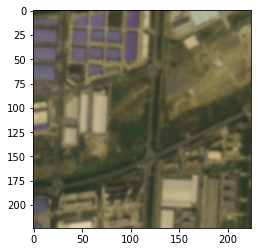

In [34]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(torch.sum(torch.isnan(images)))
print(torch.sum(torch.isinf(images)))
print(torch.unique(images))
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))